In [1]:
from sympy.abc import s, z
import sympy as sp
import numpy as np
from utils.units import u
from utils.units.sympy_helpers import without_units, split_unit_form as split_unit
from pathlib import Path

def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

out_dir = Path("./out") / "parcial1_ga"

In [2]:
gp = 406/((s+56)*(s+5))
gp = var_in(s, u.rad/u.s, gp)
gp

406/((5 + second*s/radian)*(56 + second*s/radian))

In [3]:
gc = 0.37137*(s+10.48)/s
gc = var_in(s, u.rad/u.s, gc)
gc

radian*(3.8919576 + 0.37137*second*s/radian)/(second*s)

In [4]:
from utils.units import basis
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=6716173735170344396), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [5]:
from utils.ctrl import expr2sys, sys_deu, sys2zpk
from control import matlab as m

def my_expr2sys(expr, var, tf=None):
    return expr2sys(nu.to_numeric(expr, as_expr=True), var, tf)

gp_tf = my_expr2sys(gp, s)
gc_tf = my_expr2sys(gc, s)
gcl_tf = m.feedback(gc_tf*gp_tf)

In [6]:
wd_max = gcl_tf.pole().imag |> abs |> max |> nu.to_symb$(u.rad/u.s)
wd_max.n(4)

3.934*radian/second

In [7]:
Td = (2*np.pi*u.rad)/wd_max
Td.n(4)

1.597*second

In [8]:
dt_ = Td/30
dt_.n(4)

0.05324*second

In [9]:
from utils.ctrl import nu_stepinfo
nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_tf))

{'RiseTime': 0.330239213060258*second,
 'SettlingTime': 1.02425755925721*second,
 'SettlingMin': 0.902329280782888,
 'SettlingMax': 1.06128309876141,
 'Overshoot': 6.12830987614079*percent,
 'Undershoot': 0,
 'Peak': 1.06128309876141,
 'PeakTime': 0.683698370788816*second,
 'SteadyStateValue': 1.00000000000000}

In [10]:
from utils.ratpolys import ratpoly_zpk_form

kp, ki, dt = sp.symbols("K_p K_i T")
s_bi = 2/dt*(z-1)/(z+1)
g_pi = kp+ki/s

g_pi.subs(
    s, s_bi
) |> ratpoly_zpk_form$(?, z)


(K_i*T/2 + K_p)*((z + (K_i*T - 2*K_p)/(K_i*T + 2*K_p))/(z - 1))

In [11]:
gc_d = gc |> usubs$(s, s_bi) |> usubs$(dt, dt_)
gc_d |> nu.to_numeric$(?, as_expr=True) |> ratpoly_zpk_form$(?, z)

0.474980689545085*((z - 0.563726728998948)/(z - 1))

In [12]:
gc_dtf = my_expr2sys(gc_d, z).minreal()
gc_dtf

TransferFunction(array([ 0.47498069, -0.26775931]), array([ 1., -1.]), True)

In [13]:
gp_dtf = m.c2d(gp_tf, nu[dt_])
gp_dtf

TransferFunction(array([0.23718272, 0.08453633]), array([ 1.        , -0.81698236,  0.03885757]), 0.4859463705790609)

In [14]:
gcl_dtf = m.feedback(gc_dtf * gp_dtf)
gcl_dtf

TransferFunction(array([ 0.11265721, -0.02335476, -0.02263539]), array([ 1.        , -1.70432515,  0.83248517, -0.06149295]), 0.4859463705790609)

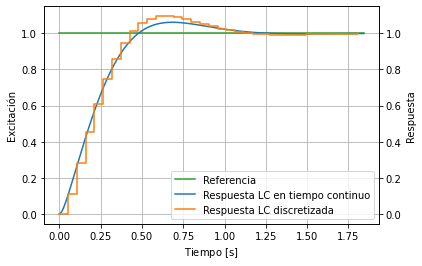

In [16]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(gcl_tf, label="Respuesta LC en tiempo continuo")
plot_step(gcl_dtf, label="Respuesta LC discretizada")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "resp_parte1.svg")

In [ ]:
nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_dtf))

{'RiseTime': 0.319460899199162*second,
 'SettlingTime': 1.01162618079735*second,
 'SettlingMin': 0.948473177626063,
 'SettlingMax': 1.09467846619817,
 'Overshoot': 9.46784661981769*percent,
 'Undershoot': 0,
 'Peak': 1.09467846619817,
 'PeakTime': 0.638921798398324*second,
 'SteadyStateValue': 0.999999999999997}

In [ ]:
from utils.ctrlsys import difference_eq
from utils.ctrl import siso_numden

difference_eq$(
    *siso_numden(gc_dtf))$(
    *map(sp.Function, ["e", "u"]))(
    sp.Symbol("k")).n(4)

Eq(u(k), 0.475*e(k) - 0.2678*e(k - 1) + 1.0*u(k - 1))